# 0. Loading all Data

In [340]:
%reload_ext autoreload
%autoreload 2
from B_model import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tensorflow import keras
all_metrics_df,testParamDf = data_generation()

Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

In [341]:
result_all = pd.read_csv('result.csv')
result_all = result_all.loc[result_all['error'] != 0]

In [342]:
result_all.shape

(4320, 8)

In [424]:
#result_all.sort_values(by = ['error'])[0:30]

In [425]:
result_all_selected = result_all.loc[result_all['error'] < 1000]
result_all_selected.shape

(3138, 8)

In [426]:
result_all_selected

,Unnamed: 0,argu,loss_fun,class_weight,nl,opt,epochs,error
0,0,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,100.0,591.884646
1,1,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,200.0,566.150001
2,2,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,300.0,496.044002
3,3,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,100.0,410.303547
4,4,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,200.0,336.877759
...,...,...,...,...,...,...,...,...
4315,4315,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,200.0,189.592158
4316,4316,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,300.0,238.871153
4317,4317,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,100.0,444.198762
4318,4318,4.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,200.0,395.259875


In [345]:
result_all_selected.groupby(['argu','opt'])['error'].aggregate([np.mean,np.median])

mean      median
argu opt                            
1.0  Adam     194.257230  185.202992
     RMSprop  188.364034  177.204078
     SGD      397.449992  391.125152
2.0  Adam     266.275444  255.289060
     RMSprop  267.817686  256.601163
     SGD      395.342975  407.504851
3.0  Adam     342.077747  320.325124
     RMSprop  315.885257  304.081920
     SGD      369.137866  360.022192
4.0  Adam     451.307279  421.179292
     RMSprop  426.000755  395.734750
     SGD      199.310046  138.679194

In [346]:
result_all_selected.groupby(['argu','class_weight'])['error'].aggregate([np.mean,np.median])

mean      median
argu class_weight                                                
1.0  {0: 1.0, 1: 1.0, 2: 1.0}              298.997804  261.115291
     {0: 10000.0, 1: 100.0, 2: 1.0}        174.756290  171.639176
     {0: 1000000.0, 1: 1000.0, 2: 1.0}     172.198406  167.591373
     {0: 100000000.0, 1: 10000.0, 2: 1.0}  169.753310  166.604034
2.0  {0: 1.0, 1: 1.0, 2: 1.0}              352.193873  345.442996
     {0: 10000.0, 1: 100.0, 2: 1.0}        243.810882  232.367225
     {0: 1000000.0, 1: 1000.0, 2: 1.0}     242.137869  235.754205
     {0: 100000000.0, 1: 10000.0, 2: 1.0}  248.501864  232.409954
3.0  {0: 1.0, 1: 1.0, 2: 1.0}              368.814163  361.529859
     {0: 10000.0, 1: 100.0, 2: 1.0}        309.861143  289.852933
     {0: 1000000.0, 1: 1000.0, 2: 1.0}     315.292518  299.181751
     {0: 100000000.0, 1: 10000.0, 2: 1.0}  322.062489  297.861540
4.0  {0: 1.0, 1: 1.0, 2: 1.0}              375.379501  379.494094
     {0: 10000.0, 1: 100.0, 2: 1.0}        429.377025  386.392877
     {0: 1000000.0, 1: 1000.0, 2: 1.0}     454.762987  441.709082
     {0: 100000000.0, 1: 10000.0, 2: 1.0}  441.009126  403.248101

In [347]:
result_all_selected.groupby(['class_weight','opt'])['error'].aggregate([np.mean,np.median])

mean      median
class_weight                         opt                            
{0: 1.0, 1: 1.0, 2: 1.0}             Adam     347.427860  323.865779
                                     RMSprop  342.553986  332.541979
                                     SGD      352.725586  347.173818
{0: 10000.0, 1: 100.0, 2: 1.0}       Adam     300.163899  261.338810
                                     RMSprop  275.611141  247.399743
                                     SGD      371.658489  371.658489
{0: 1000000.0, 1: 1000.0, 2: 1.0}    Adam     303.291166  264.898959
                                     RMSprop  285.389503  247.597280
{0: 100000000.0, 1: 10000.0, 2: 1.0} Adam     295.721924  253.650163
                                     RMSprop  292.923593  250.101132

In [348]:
result_all_selected.groupby(['argu','loss_fun'])['error'].aggregate([np.mean,np.median])

mean      median
argu loss_fun                        
1.0  mae       183.332418  175.689755
     mse       245.626278  215.880016
2.0  mae       255.832669  244.051956
     mse       303.833432  291.278550
3.0  mae       295.731755  285.989752
     mse       371.327928  364.081318
4.0  mae       352.641412  327.448383
     mse       500.434417  471.111725

In [349]:
result_all_selected.groupby(['argu','nl'])['error'].aggregate([np.mean,np.median])

mean      median
argu nl                                       
1.0  [100, 50, 30, 10]  211.932152  179.208335
     [100, 80, 30, 10]  206.575620  187.684646
     [100, 80, 60, 10]  206.187545  191.936158
     [100, 80, 60, 40]  219.433822  194.443128
     [30, 10]           224.161498  186.218808
     [50, 30, 10]       220.088666  199.860825
     [60, 10]           214.641374  185.557797
     [60, 40]           227.114591  205.537740
     [70, 50, 30, 10]   208.041062  185.161104
     [80, 30, 10]       197.765480  169.583390
     [80, 60, 10]       209.200838  184.649356
     [80, 60, 40]       223.554534  183.043376
     [90, 10]           204.739439  175.991356
     [90, 40]           214.575100  201.379650
     [90, 70]           228.367720  200.597511
2.0  [100, 50, 30, 10]  260.855964  237.620157
     [100, 80, 30, 10]  269.208100  228.989430
     [100, 80, 60, 10]  276.157994  256.302952
     [100, 80, 60, 40]  294.873747  273.078142
     [30, 10]           299.198518  286.496297
     [50, 30, 10]       276.519324  266.943523
     [60, 10]           276.060531  237.656200
     [60, 40]           305.335782  284.072759
     [70, 50, 30, 10]   275.352317  250.413032
     [80, 30, 10]       270.931223  257.756552
     [80, 60, 10]       258.549868  260.826054
     [80, 60, 40]       297.109541  294.607728
     [90, 10]           250.543044  241.688695
     [90, 40]           286.856423  278.284939
     [90, 70]           296.280429  282.685018
3.0  [100, 50, 30, 10]  312.435549  294.297660
     [100, 80, 30, 10]  309.435994  286.719479
     [100, 80, 60, 10]  300.614744  289.544336
     [100, 80, 60, 40]  339.589124  327.380233
     [30, 10]           367.881913  339.999980
     [50, 30, 10]       331.696613  307.447264
     [60, 10]           328.701977  318.477183
     [60, 40]           366.657053  343.744276
     [70, 50, 30, 10]   332.666162  298.030486
     [80, 30, 10]       340.383279  311.165764
     [80, 60, 10]       316.796000  324.322302
     [80, 60, 40]       363.864419  363.064096
     [90, 10]           306.234524  300.888965
     [90, 40]           331.331585  321.480632
     [90, 70]           333.282613  298.923511
4.0  [100, 50, 30, 10]  439.280496  416.828198
     [100, 80, 30, 10]  380.649106  371.004828
     [100, 80, 60, 10]  384.471534  336.981444
     [100, 80, 60, 40]  444.148084  410.058223
     [30, 10]           435.376299  433.020132
     [50, 30, 10]       395.307174  383.087378
     [60, 10]           413.530579  384.319432
     [60, 40]           483.244319  463.624788
     [70, 50, 30, 10]   417.904742  389.074827
     [80, 30, 10]       401.098544  374.726512
     [80, 60, 10]       386.065378  354.322606
     [80, 60, 40]       463.712784  471.578209
     [90, 10]           381.793732  340.444455
     [90, 40]           454.884243  453.774320
     [90, 70]           442.474163  440.242775

In [350]:
result_all_selected.groupby(['argu','epochs'])[['error']].aggregate([np.mean,np.median]).round(0)

error       
              mean median
argu epochs              
1.0  100.0   242.0  219.0
     200.0   204.0  180.0
     300.0   197.0  171.0
2.0  100.0   314.0  307.0
     200.0   274.0  266.0
     300.0   250.0  235.0
3.0  100.0   381.0  357.0
     200.0   322.0  302.0
     300.0   293.0  281.0
4.0  100.0   486.0  454.0
     200.0   407.0  392.0
     300.0   374.0  358.0

In [351]:
top_30 = result_all.sort_values(by = ['error'])[0:30].index

In [352]:
top_30

Int64Index([3881, 3780, 3872, 3834, 3789, 3843, 3827, 3863, 3835, 3809, 3825,
            4100, 3845, 3562, 1022, 2048, 3791, 3871,  715,  724,  287,  167,
             430,  984,  779,  859, 3907, 3880,  770, 3861],
           dtype='int64')

# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

# 1. Data Preparation

In [353]:
# 2nd Order Raw only!
test_coef = ["0","2","3","4","exponential"]
func_coef = ["raw","second","third","forth","exponential"]
for i in range(0,1):
    globals()[f'X{test_coef[i]}'],globals()[f'y{test_coef[i]}'],globals()[f'Y{test_coef[i]}'],globals()[f'X_Y_merged{test_coef[i]}'] = \
        eval(func_coef[i]+"_order_poly_fitting(all_metrics_df,testParamDf)")

## 1.1 Choose a Data Version

In [354]:
version = '0' #raw ones
X,y,Y,X_Y_merged = eval('X'+version),eval('y'+version),eval('Y'+version),eval('X_Y_merged'+version)
objective = eval('objective_'+version)

## 1.2 Models Construction

In [355]:
model_raw = battery_model(0,X,y,Y,X_Y_merged,objective)

## 1.3 Data Argumentation

### (Reset)

# 2. Training

In [356]:
pd.options.mode.chained_assignment = None  # default='warn'

```python
index = 0  
for i0 in argu_all:
    model_raw_copy1 = copy.deepcopy(model_raw)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    for i1 in loss_fun_all:
        for i2 in class_weight_all:
            for i3 in nl_all:
                for i4 in opt_all:
                    for i5 in epochs_all:
                        model_raw_copy = copy.deepcopy(model_raw_copy2)
                        result['argu'][index] = i0
                        result['loss_fun'][index] = i1
                        result['class_weight'][index] = "{}".format(i2)
                        result['nl'][index] = "{}".format(i3)
                        result['opt'][index] = i4
                        result['epochs'][index] = i5
                        result['error'][index] = model_raw_copy.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0)
                        index+=1
                        print (i0,i1,i2,i3,i4,i5)
```


# Result

In [337]:
#argu	loss_fun	class_weight	nl	opt	epochs	
i = 3881
i0 = int(result_all['argu'][i])
i1 = result_all['loss_fun'][i]
i2 =eval(result_all['class_weight'][i])

i3 = eval(result_all['nl'][i])

i4 = result_all['opt'][i]
i5 = int(result_all['epochs'][i])

In [414]:
model_raw_copy = copy.deepcopy(model_raw)

In [157]:
records = []
for i in top_30:
    i0 = int(result_all['argu'][i])
    i1 = result_all['loss_fun'][i]
    i2 =eval(result_all['class_weight'][i])
    i3 = eval(result_all['nl'][i])
    i4 = result_all['opt'][i]
    i5 = int(result_all['epochs'][i])
    
    model_raw_copy1 = copy.deepcopy(model_raw_copy)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    records.append(model_raw_copy2.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0))


2021-11-24 03:31:39.019986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:39.156386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:53.849125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:53.976765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:54.091651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:58.640705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 03:31:58.767314: I tensorflow/core/grappler/optimizers/cust

In [415]:
records_array = np.array(records)
select = top_30[np.argsort(records_array) == 10][0]
display(result_all.loc[2048])
#859 - Good
#770 not bad
#3825 overfitting / underfitting???
# 3881 -> WHen input dimension high (4) -> Hard to differeate those value -> tend to predict the same
# reject 4 dimension argument 


Unnamed: 0                                      2048
argu                                             2.0
loss_fun                                         mae
class_weight    {0: 100000000.0, 1: 10000.0, 2: 1.0}
nl                                  [70, 50, 30, 10]
opt                                             Adam
epochs                                         300.0
error                                      70.526142
Name: 2048, dtype: object

2021-11-24 11:18:05.218091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:18:05.447863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:18:25.142240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


216.33146565659862

In [419]:

i0 = 3
i1 = 'mae'
i2 = {0: 10000000.0, 1: 1000.0, 2: 1.0}
i3 = [100,70,50,20]
i4 = 'adam'
i5 = 200
model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(i0)
model_raw_copy2 = copy.deepcopy(model_raw_copy1)
model_raw_copy2.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0)

2021-11-24 11:19:42.604969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:19:42.743418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 11:19:59.486360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


182.9357358916199

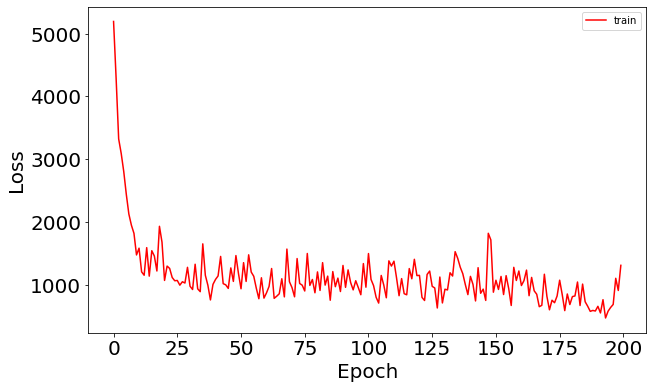

In [420]:
model_raw_copy2.loss_function_plot()

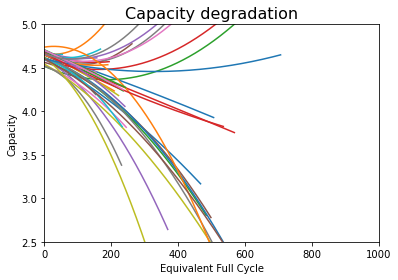

In [421]:
model_raw_copy2.plot_curve("test",all_metrics_df,1000,2.5)

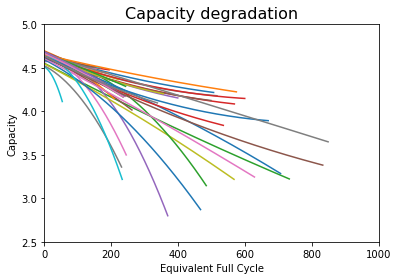

In [422]:
model_raw_copy2.plot_curve("test_true",all_metrics_df,1000,2.5)